In [71]:

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from IPython.core.display import HTML
import seaborn as sns
import re
%matplotlib inline

css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

## Data Gathering and EDA

Importing the data into a **pandas Dataframe**

In [72]:
titles = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

In [73]:
titles=titles.set_index('movie_title')

Creating a ratio field for profit percentage

In [74]:
titles['ratio']=titles.gross/titles.budget

In [75]:
titles=titles=titles.dropna(axis=0, subset=['imdb_score','gross', 'budget', 'ratio', 'director_facebook_likes' , 'content_rating' , 'title_year' , 'movie_facebook_likes' ])

Checking the distribution of **movie ratings**.  
Low frequency ratings are removed later to improve prediction accuracy.


In [76]:
titles.content_rating.value_counts()

R            1737
PG-13        1331
PG            576
G              91
Not Rated      42
Unrated        24
Approved       17
X              10
NC-17           6
Passed          3
M               2
GP              1
Name: content_rating, dtype: int64

**Analyzing `imdb` score disctribution**

In [77]:
((titles.imdb_score//1)).value_counts()

6.0    1459
7.0    1091
5.0     769
4.0     217
8.0     211
3.0      64
2.0      22
9.0       4
1.0       3
Name: imdb_score, dtype: int64

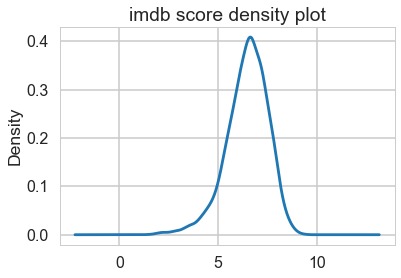

In [78]:
titles.imdb_score.plot.kde(title='imdb score density plot' )

In [79]:
titles.genres=titles.genres.str.replace("\|.*","")


**Analyzing Genre Distribution of the movies**

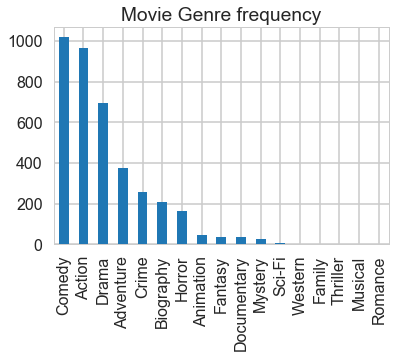

In [80]:
titles.genres.value_counts().plot(kind = 'bar', title='Movie Genre frequency')

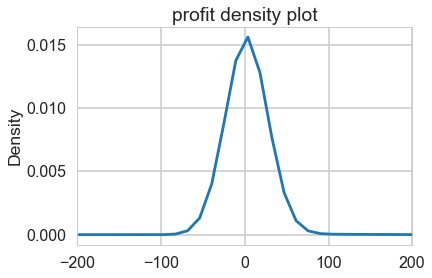

In [81]:
titles.ratio.plot.kde(xlim=[-200,200] , title='profit density plot')

** looking for outliers in profit ratio. To improve efficiency of the model **


In [82]:
(titles.ratio//100).value_counts()

0.0     3823
1.0        9
2.0        2
3.0        2
71.0       1
4.0        1
27.0       1
23.0       1
Name: ratio, dtype: int64

**removing movies with a very high profit ratio (>200x) for which are mostly low budget movies**

In [83]:
titles=titles.drop(titles[(titles.ratio>200)].index)

In [84]:
titles.ratio.mean() , titles.ratio.std() 


(2.7023612667579786, 8.60812467633687)

## Profit distribution
**Majority of movies make a loss**


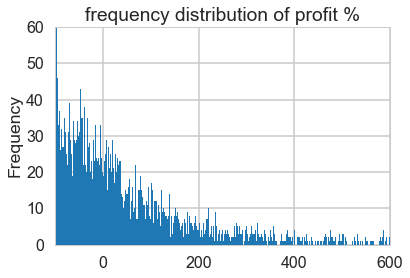

In [215]:
((titles.ratio -1 )*100).plot.hist(xlim=[-100,600],ylim=[0,60],bins=10000,title="frequency distribution of profit %")


In [86]:
titles.ratio.mean() , titles.ratio.std() , titles.ratio.median() 

(2.7023612667579786, 8.60812467633687, 1.081657044736842)

**Defining the criterion of a classifying a movie as profit making. 
Choosing a value well above the median:: `20%` profit**


In [87]:
titles['profit_making']= (titles.ratio > 1.2)

In [88]:
titles.profit_making.value_counts()

False    2059
True     1773
Name: profit_making, dtype: int64

##  Sending budget and likes through normalizer


In [89]:
def normalize(array1, name):
    print ("normalizing "+name);
    array=array1
    array=array/array.std()
    array=array-array.mean()
    return(array);

In [90]:
for column in ['budget','movie_facebook_likes','cast_total_facebook_likes','director_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','duration','num_voted_users', 'num_user_for_reviews', 'gross']:
    if np.issubdtype(titles[column].dtype, np.number):
        print (column + ": true")
        titles[column]=normalize(array1=titles[column],name=column)
    else:
        print (column + ":false")

budget: true
normalizing budget
movie_facebook_likes: true
normalizing movie_facebook_likes
cast_total_facebook_likes: true
normalizing cast_total_facebook_likes
director_facebook_likes: true
normalizing director_facebook_likes
actor_1_facebook_likes: true
normalizing actor_1_facebook_likes
actor_2_facebook_likes: true
normalizing actor_2_facebook_likes
duration: true
normalizing duration
num_voted_users: true
normalizing num_voted_users
num_user_for_reviews: true
normalizing num_user_for_reviews
gross: true
normalizing gross


In [91]:
titles2 = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

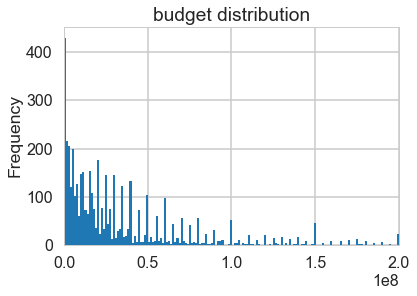

In [92]:
(titles2.budget).plot.hist(bins=10000,xlim=[0,200e6],title="budget distribution")


** Vital budget statistics in $ million** 

In [93]:
titles2.budget.mean()/1e6 , titles2.budget.std()/1e6 , titles2.budget.median()/1e6


(39.75262043638761, 206.11489844868385, 20.0)

In [94]:
((titles2.budget//10000000)).value_counts().sort_index()


0.0       1457
1.0        803
2.0        579
3.0        406
4.0        260
5.0        217
6.0        179
7.0        122
8.0         93
9.0         60
10.0        71
11.0        32
12.0        38
13.0        34
14.0        27
15.0        47
16.0        15
17.0        24
18.0        11
19.0         7
20.0        28
21.0         5
22.0         7
23.0         2
24.0         1
25.0         9
26.0         2
30.0         2
39.0         1
40.0         1
55.0         1
60.0         1
70.0         2
100.0        1
110.0        1
212.0        1
240.0        1
250.0        1
420.0        1
1221.0       1
Name: budget, dtype: int64

#### Splitting titles into low budget and high budget movies

In [95]:
titles_highb = titles[(titles.budget > -.114)]

In [96]:
titles_lowb = titles[(titles.budget <= -.114)]

In [97]:
len(titles_highb)

2052

In [98]:
len(titles_lowb)

1780

In [99]:
titles_highb.profit_making.mean()

0.40692007797270957

In [100]:
titles_lowb.profit_making.mean()

0.52696629213483148

In [101]:
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle


In [102]:
titles_highb=shuffle(titles_highb)

In [103]:
titles_highb=titles_highb[['imdb_score','gross', 'budget', 'ratio', 'director_facebook_likes' , 'content_rating' , 'title_year' , 'movie_facebook_likes' ,'actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes']]

In [104]:
titles_highb=titles_highb.dropna(axis=0, subset = ['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes'])

In [105]:
titles_highb_train=titles_highb[:1500]
titles_highb_test=titles_highb[1500:]

In [106]:
titles_cat=titles

In [107]:
from pandas import get_dummies

In [108]:
type (titles_cat)

pandas.core.frame.DataFrame

#### **Converting non quantitative data items (Genres and Ratings) into features**

In [109]:
titles_cat=pd.get_dummies(titles_cat , columns=["genres"])

In [110]:
titles_cat.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_3_facebook_likes', 'actor_2_name',
       'actor_1_facebook_likes', 'gross', 'actor_1_name', 'num_voted_users',
       'cast_total_facebook_likes', 'actor_3_name', 'facenumber_in_poster',
       'plot_keywords', 'movie_imdb_link', 'num_user_for_reviews', 'language',
       'country', 'content_rating', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'ratio', 'profit_making', 'genres_Action',
       'genres_Adventure', 'genres_Animation', 'genres_Biography',
       'genres_Comedy', 'genres_Crime', 'genres_Documentary', 'genres_Drama',
       'genres_Family', 'genres_Fantasy', 'genres_Horror', 'genres_Musical',
       'genres_Mystery', 'genres_Romance', 'genres_Sci-Fi', 'genres_Thriller',
       'genres_Western'],
      dtype='object')

In [111]:
titles_cat.content_rating.value_counts()

R            1730
PG-13        1331
PG            576
G              91
Not Rated      42
Unrated        23
Approved       17
X              10
NC-17           6
Passed          3
M               2
GP              1
Name: content_rating, dtype: int64

** Removing low frequency ratings instances **

In [112]:
titles_cat=titles_cat.drop(titles_cat[titles_cat.content_rating.str.match("NC-17|Passed|M|GP")].index)

In [113]:
titles_cat=pd.get_dummies(titles_cat , columns=["content_rating"])

In [114]:
titles_cat_highb = titles_cat[(titles_cat.budget > -.114)]

In [115]:
titles_cat_lowb = titles_cat[(titles_cat.budget <= -.114)]

In [116]:
len(titles_cat_highb)

2051

In [117]:
len(titles_cat_lowb)

1769

In [118]:
titles_cat_highb.profit_making.mean()

0.40711847879083374

In [119]:
titles_cat_lowb.profit_making.mean()

0.52572074618428488

In [120]:
titles_cat_highb=shuffle(titles_cat_highb)

#### Looks like financial data of foreign movies is not reported in USD. Will need to clean up these data points

In [121]:
titles2[(titles2.budget>500e6)].country.value_counts()

Japan          4
South Korea    2
India          2
China          1
Hungary        1
Spain          1
Name: country, dtype: int64

In [122]:
len(titles_cat_highb[titles_cat_highb.country != "USA"])

339

** Removing foreign movies from the Dataset. Maybe add currency conversion in the future**

In [123]:
titles_cat_highb=titles_cat_highb.drop(titles_cat_highb[titles_cat_highb.country != "USA"].index)

In [124]:
titles_cat_ml_highb=titles_cat_highb.select_dtypes(exclude=['object']) 

In [125]:
titles_cat_ml_highb=titles_cat_ml_highb.select_dtypes(exclude=['bool']) 

In [126]:
titles_cat_ml_highb=titles_cat_ml_highb.dropna()

In [127]:
titles_cat_ml_highb=shuffle(titles_cat_ml_highb)

In [128]:
titles_cat_ml_highb.columns

Index(['num_critic_for_reviews', 'duration', 'director_facebook_likes',
       'actor_3_facebook_likes', 'actor_1_facebook_likes', 'gross',
       'num_voted_users', 'cast_total_facebook_likes', 'facenumber_in_poster',
       'num_user_for_reviews', 'budget', 'title_year',
       'actor_2_facebook_likes', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'ratio', 'genres_Action', 'genres_Adventure',
       'genres_Animation', 'genres_Biography', 'genres_Comedy', 'genres_Crime',
       'genres_Documentary', 'genres_Drama', 'genres_Family', 'genres_Fantasy',
       'genres_Horror', 'genres_Musical', 'genres_Mystery', 'genres_Romance',
       'genres_Sci-Fi', 'genres_Thriller', 'genres_Western',
       'content_rating_Approved', 'content_rating_G',
       'content_rating_Not Rated', 'content_rating_PG', 'content_rating_PG-13',
       'content_rating_R', 'content_rating_Unrated', 'content_rating_X'],
      dtype='object')

In [129]:
titles2 = pd.DataFrame.from_csv('movie_metadata.csv', index_col=None)

In [130]:
titles2=titles2.set_index('movie_title')

In [131]:
titles2['ratio']=titles2.gross/titles2.budget

In [134]:
titles2=titles2.drop(titles2[titles2.country!="USA"].index)

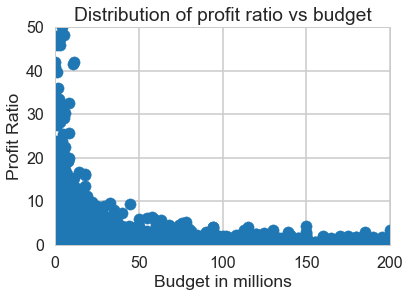

In [137]:
#plt.ylim=[0,500]
#plt.xlim=[0,.2e10]
plt.axis([0,200,0,50])
plt.xlabel('Budget in millions')
plt.ylabel('Profit Ratio')
plt.title('Distribution of profit ratio vs budget')
plt.scatter(titles2.budget/(1e6) , titles2.ratio)
plt.show()

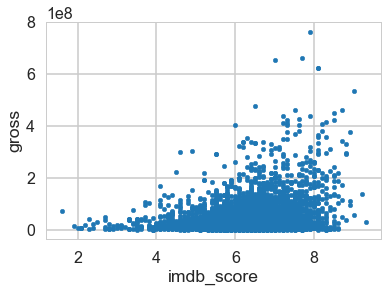

In [138]:
titles2.plot.scatter(x='imdb_score',y='gross')

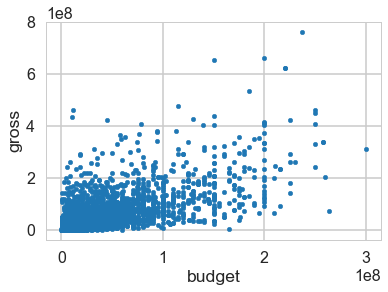

In [139]:
titles2.plot.scatter(x='budget',y='gross')

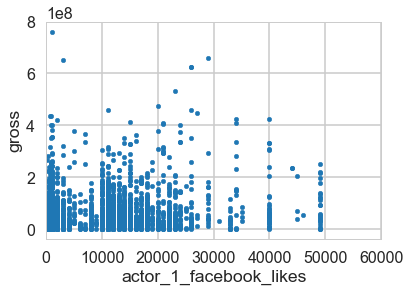

In [143]:
titles2.plot.scatter(x='actor_1_facebook_likes',y='gross', xlim=[0,60000])

## Classification

## `Logistic Regression `

In [144]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [145]:
logistic_regression_1= LogisticRegression()

In [146]:
titles_cat_ml_highb=titles_cat_highb.select_dtypes(exclude=['object']) 

In [147]:
titles_cat_ml_highb_ratio=titles_cat_ml_highb.ratio

In [148]:
titles_cat_logistic_highb=titles_cat_ml_highb.drop(['ratio'], axis=1)

In [149]:
titles_cat_logistic_highb=titles_cat_logistic_highb.dropna()

In [150]:
titles_cat_logistic_highb=shuffle(titles_cat_logistic_highb)

In [151]:
titles_cat_logistic_highb_train=titles_cat_logistic_highb[:1200]
titles_cat_logistic_highb_test=titles_cat_logistic_highb[1200:]

In [152]:
titles_cat_logistic_highb_train_x=titles_cat_logistic_highb_train.drop(['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1 )

In [153]:
titles_cat_logistic_highb_test_x=titles_cat_logistic_highb_test.drop( ['gross', 'profit_making','movie_facebook_likes','num_voted_users' ],axis=1)

In [154]:
titles_cat_logistic_highb_train_y=pd.DataFrame(titles_cat_logistic_highb_train['profit_making'])

In [155]:
titles_cat_logistic_highb_test_y=pd.DataFrame(titles_cat_logistic_highb_test[ 'profit_making' ])

In [156]:
logistic_regression_1.fit(titles_cat_logistic_highb_train_x,titles_cat_logistic_highb_train_y.profit_making)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [157]:
accuracy_score(logistic_regression_1.predict(titles_cat_logistic_highb_test_x),titles_cat_logistic_highb_test_y.profit_making)

0.68577075098814233

In [159]:
logistic_regression_2=LogisticRegression()

In [160]:
titles_cat_lowb=titles_cat_lowb.drop(titles_cat_lowb[titles_cat_lowb.country!="USA"].index)

In [161]:
titles_cat_ml_lowb=titles_cat_lowb.select_dtypes(exclude=['object']) 

In [162]:
titles_cat_ml_lowb_ratio=titles_cat_ml_lowb.ratio

In [163]:
titles_cat_logistic_lowb=titles_cat_ml_lowb.drop(['ratio'], axis=1)

In [164]:
titles_cat_logistic_lowb=titles_cat_logistic_lowb.dropna()

In [165]:
titles_cat_logistic_lowb=shuffle(titles_cat_logistic_lowb)

In [166]:
titles_cat_logistic_lowb_train=titles_cat_logistic_lowb[:1200]
titles_cat_logistic_lowb_test=titles_cat_logistic_lowb[1200:]

In [167]:
titles_cat_logistic_lowb_train_x=titles_cat_logistic_lowb_train.drop(['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1 )

In [168]:
titles_cat_logistic_lowb_test_x=titles_cat_logistic_lowb_test.drop( ['gross', 'profit_making','movie_facebook_likes','num_voted_users'],axis=1)

In [169]:
titles_cat_logistic_lowb_train_y=pd.DataFrame(titles_cat_logistic_lowb_train['profit_making'])

In [170]:
titles_cat_logistic_lowb_test_y=pd.DataFrame(titles_cat_logistic_lowb_test[ 'profit_making' ])

In [171]:
logistic_regression_2.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [172]:
accuracy_score(logistic_regression_2.predict(titles_cat_logistic_lowb_test_x),titles_cat_logistic_lowb_test_y.profit_making)

0.73972602739726023

In [173]:
accuracy_score(logistic_regression_2.predict(titles_cat_logistic_lowb_train_x),titles_cat_logistic_lowb_train_y.profit_making)

0.68666666666666665

## `Support Vector Machine`

In [174]:
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [175]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=10, C=.1))
])


In [176]:
poly_kernel_svm_clf.fit(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.1, cache_size=200, class_weight=None, coef0=10,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [177]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_test_x,titles_cat_logistic_lowb_test_y.profit_making)

0.73972602739726023

In [178]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_train_x,titles_cat_logistic_lowb_train_y.profit_making)

0.77916666666666667

In [179]:
titles_cat_logistic_lowb_train_x_noimdb=titles_cat_logistic_lowb_train_x.drop('imdb_score',axis=1)

In [180]:
titles_cat_logistic_lowb_test_x_noimdb=titles_cat_logistic_lowb_test_x.drop('imdb_score',axis=1)

## `Logistic Regression`

In [185]:
lgr = Pipeline([
        ("scaler", StandardScaler()),
        ("lgr_clf", LogisticRegression(C=.1))
])

In [186]:
lgr.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [187]:
lgr.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.76712328767123283

In [188]:
lgr.score(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

0.71166666666666667

In [189]:
poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=10, C=.01))
])

In [190]:
poly_kernel_svm_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.01, cache_size=200, class_weight=None, coef0=10,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [191]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.71232876712328763

In [192]:
poly_kernel_svm_clf.score(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

0.73833333333333329

In [196]:
##Voting


In [197]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

voting_clf = VotingClassifier(
       estimators=[('lr',lgr ),  ('svc', poly_kernel_svm_clf)],
       #estimators=[('svc', poly_kernel_svm_clf)],
    voting='hard')
#voting_clf.fit(X_train, y_train)


In [198]:
voting_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making )

VotingClassifier(estimators=[('lr', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          pena... max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [199]:
voting_clf.estimators

[('lr', Pipeline(memory=None,
       steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
            intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
            penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
            verbose=0, warm_start=False))])), ('svc', Pipeline(memory=None,
       steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=0.01, cache_size=200, class_weight=None, coef0=10,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False))]))]

In [200]:
voting_clf.score(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

0.72499999999999998

In [201]:
voting_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.73972602739726023

## `Random forest` 

In [206]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=100, n_jobs=-1, random_state=42)

In [207]:
rnd_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=100,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [208]:
rnd_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.79452054794520544

In [212]:

voting_clf = VotingClassifier(
       estimators=[('lr',lgr ),  ('svc', poly_kernel_svm_clf),  ('rnd', rnd_clf)],
       #estimators=[('svc', poly_kernel_svm_clf)],
    voting='hard')
#voting_clf.fit(X_train, y_train)


In [213]:
voting_clf.fit(titles_cat_logistic_lowb_train_x_noimdb,titles_cat_logistic_lowb_train_y.profit_making )

VotingClassifier(estimators=[('lr', Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lgr_clf', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          pena...mators=1000, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [214]:
voting_clf.score(titles_cat_logistic_lowb_test_x_noimdb,titles_cat_logistic_lowb_test_y.profit_making)

0.76712328767123283